# Построение рекомендательной системы  при помощи библиотеки Surprise with Python. 


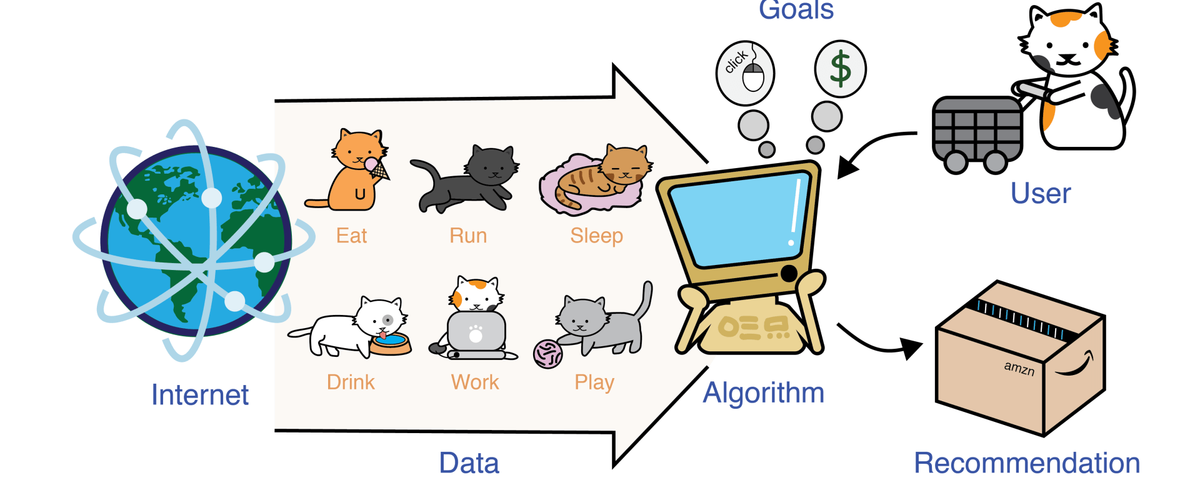





Данная работа выполнена в рамках  <a href="https://gpn-cup.ru/" target="_blank">GPN Intelligence Cup осень 2021</a> по направлению Data Science. В связи с  ограничениями размера сохраняемых файлов на Github  исходные данные для данного проекта можно скачать по <a href="https://drive.google.com/file/d/1Vk0EJmtzXNPgIBWeQS4KJvhCtZ_6e87r/view?usp=sharing" target="_blank">этой ссылке</a> и распаковать в директорию данного ноутбука перед исполнением кода.

В качестве рекомендательной системы используется  библиотека <a href="http://surpriselib.com/" target="_blank">Surprise</a> и некоторые функции,приведенные на ее официальном сайте.


## 1. Анализ входных данных

Импортируем нужные модули и экспортируем данные из исходных файлов для анализа  и выбора дальнейшего решения:

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import skew
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.model_selection import train_test_split

pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
sku_raw = pd.read_parquet('nomenclature.parquet')
trans_raw = pd.read_parquet('transactions.parquet')

trans_subm_raw = pd.read_parquet('transactions-for_submission.parquet') 
submis_sample = pd.read_parquet('submission-example.parquet')

# Проверяем sku NaN - не входят ли они в требуемую нам категорию
print("Размерность массива sku товаров: ", sku_raw.shape)
print("Сума NaN величин sku товаров\n ", sku_raw.isna().sum())
sku_nan = sku_raw[sku_raw.isna().any(axis=1)]
print("\nСписок товаров с NaN sku\n:", sku_nan)

Размерность массива sku товаров:  (5103, 7)
Сума NaN величин sku товаров
  sku_id       0
full_name    9
brand        9
sku_group    0
OTM          9
units        9
country      9
dtype: int64

Список товаров с NaN sku
:       sku_id full_name brand                                  sku_group   OTM  \
3724    1158      None  None                                Ethereum 92  None   
3727    1157      None  None                          Ethereum 95 бренд  None   
3728    1163      None  None       Топливо варповое с присадками летнее  None   
3771    1160      None  None                    Топливо варповое зимнее  None   
3787    1159      None  None                                Ethereum 95  None   
3825    1162      None  None       Топливо варповое с присадками зимнее  None   
3858    2032      None  None                         Ethereum 100 бренд  None   
4407    1161      None  None                    Топливо варповое летнее  None   
4922    1771      None  None  Топливо варповое с п

In [2]:
print("\n1. Размерность `transactions` dataset: строк: {:,}, столбцов: {}.".format(
    trans_raw.shape[0],trans_raw.shape[1]))
print("Сумма NaN значений столбцов для `transactions` dataset:") 
print(trans_raw.isna().sum())
print("Доля транцзакций без client_id  для `transactions` dataset\
 - {:.3%}.".format(trans_raw.isna().sum().client_id/trans_raw.shape[0]))

print("\n2. Размерность `transactions` dataset: строк: {:,}, столбцов: {}.".format(
    trans_subm_raw.shape[0],trans_subm_raw.shape[1]))
print("Сумма NaN значений столбцов `transactions_for_submision` dataset") 
print(trans_subm_raw.isna().sum())
print("Доля транцзакций без  client_id для `transactions_for_submission` dataset\
 - {:.3%}.".format(trans_subm_raw.isna().sum().client_id/trans_subm_raw.shape[0]))


1. Размерность `transactions` dataset: строк: 7,620,119, столбцов: 8.
Сумма NaN значений столбцов для `transactions` dataset:
sku_id             0
price              0
number             0
cheque_id          0
litrs              0
client_id    3772355
shop_id            0
date               0
dtype: int64
Доля транцзакций без client_id  для `transactions` dataset - 49.505%.

2. Размерность `transactions` dataset: строк: 554,730, столбцов: 8.
Сумма NaN значений столбцов `transactions_for_submision` dataset
sku_id            0
price             0
number            0
cheque_id         0
litrs             0
client_id    271870
shop_id           0
date              0
dtype: int64
Доля транцзакций без  client_id для `transactions_for_submission` dataset - 49.009%.


Создаем фильтр требуемых нам товаров на основании sku_id и требуемых нам категорий:

In [3]:
sku_group_filter = [ 'Вода', 'Сладкие Уранированные напитки, холодный чай' , 
                    'Кофейные напитки с молоком',  'Энергетические напитки',
                    'Снеки', 'Соки и сокосодержащие напитки']
sku_filter = []
for value in sku_group_filter:
    sku_filter.extend(list(sku_raw[sku_raw.sku_group==value].sku_id.values))

# Отделяем транцзакции и чеки по нужным  для рекомендательной системы категориям
trans = trans_raw[trans_raw.sku_id.isin(sku_filter)].reset_index()
trans_subm = trans_subm_raw[trans_subm_raw.sku_id.isin(sku_filter)].reset_index()
trans = trans[["client_id","sku_id", "number", "cheque_id"]]
trans_subm = trans_subm_raw[trans_subm_raw.sku_id.isin(sku_filter)].reset_index()

# Проверяем совпвдение сlient_id в транцакциях и транзакциях для рекомендаций
client_id_trans = trans.client_id.unique()
client_id_trans_submis = trans_subm.client_id.unique()
# Проверяем  client_id
submis_subset = set(client_id_trans_submis).issubset(set(client_id_trans))
print("Является ли множество client_id из `transactions_for_submision` подмножеством `transactions`:",submis_subset )

Является ли множество client_id из `transactions_for_submision` подмножеством `transactions`: False


Как видно выше в транзакциях  в обоих датасетах нет половины идентификаторов клиентов.
Методы импутации недостающих в данных в Pytnon не обладают высокой <a href="https://machinelearningmastery.com/handle-missing-data-python/" target="_blank">точностью</a>, можно все NaN величины заполнить средним значением — но это обманывать самого себя.  Кроме того база транзакций содержит нулевые  и вещественные данные менее единицы в полях  `number` товаров что заставляет усомнится  в `number`  как  объективном  и достоверном показателе. 

Для построения рекомендательной системы я предлагаю использовать sku_id как user_id, 
ввести новую переменную item_id через конвертацию числового значения  sku_id в виде текста, и каждый sku_id присваивает   item_id рейтинг от  1 до 20 на основе счетчиков в транзациях.  В Surprise сохраняем все настройки для simularity  как для пользователя. 

* Sadly, the scikit-learn implementations of naive bayes, decision trees and k-Nearest Neighbors are not robust to missing values.

In [4]:
# =============================================================================
# # Группируем  данные по счетчику проданных SKU для формирования рейтинга 
# для `transactions` и  `transactions-for_submission` провераем что sku_id 
# второго dataset являются подмножеством первого
# =============================================================================
sku_stat = trans.groupby(["sku_id"]).agg({"sku_id":"count"})
sku_stat.rename(columns={"sku_id":"sell_count"}, inplace=True)
sku_stat.reset_index(inplace=True)

sku_stat_subm = trans_subm.groupby(["sku_id"]).agg({"sku_id":"count"})
sku_stat_subm.rename(columns={"sku_id":"sell_count" }, inplace=True)
sku_stat_subm.reset_index(inplace=True)
sku_stat_subm_subset =set(sku_stat.sku_id).issubset(sku_stat_subm.sku_id) 


# Видим что множества не совпаюат и строим две модели рейтинга для 
# `transactions` и `transactions-for_submission` 

print("Skew для сумм транзакций товаров  в `transactions` - {:.3f}.".format(
    skew(sku_stat.sell_count.values)))

print("Skew для сумм транзакций товаров в `transactions-for_submission`- \
{:.3f}.".format(skew(sku_stat_subm.sell_count.values)))
print("Является ли множество sku_id в `transactions-for_submission` подмножеством `transactions`?:",\
    sku_stat_subm_subset)

Skew для сумм транзакций товаров  в `transactions` - 9.097.
Skew для сумм транзакций товаров в `transactions-for_submission`- 5.748.
Является ли множество sku_id в `transactions-for_submission` подмножеством `transactions`?: False


Как мы видим, нельзя посчитать рейтинг по транзакциям используя только данные `transactions` так как множество sku_id различное для `transactions-for_submission`. Поэтому определяем функцию для расчета рейтинга, так как значение  модуля skew намного больше  1, распределение очень не симметричное то  используем логарифмическую шкалу для расчета рейтингов. Удалять outliers в данном случае бессмысленно, так как мы просто потеряем ценные для нас данные.

In [5]:
def fillrating(dfcolumn):
    column_in = dfcolumn.copy()
    column_out = column_in.copy()
    column_out.values[:] =float("nan")    
    column_out.rename("out", inplace = True)                                                        
    if column_in.values.min() <= 0:
        return "Number must be positive value!"
    scale = np.logspace(np.log(column_in.values.min()), 
                        np.log(column_in.values.max()-1), num=21, 
                        base = np.exp(1))
    
    scale_range = [[scale[i], scale[i+1]] for i in range(len(scale)-1)]
    for i, val in  enumerate(column_in.values):
        for j, ranges in enumerate(scale_range):
            if val >=ranges[0] and val < ranges[1]:
                column_out.values[i] = j + 1
            if val == column_in.values.max():
                column_out.values[i] = len(scale_range)
    return column_out

# Создаем  два дата фрейма, для построения рекомендательных систем 
# sku_id будет выступать в роли user_id для      
item_trans_rating = sku_stat.copy()
item_trans_rating["item_id"] = item_trans_rating["sku_id"].astype(str)
item_trans_rating["rating"] = fillrating(item_trans_rating.sell_count)


item_subm_rating = sku_stat_subm.copy()
item_subm_rating["item_id"] = item_subm_rating ["sku_id"].astype(str)
item_subm_rating["rating"] = fillrating(item_subm_rating .sell_count)

item_trans_intersect = set(item_trans_rating.sku_id) & \
                        set(item_subm_rating.sku_id)
item_subm_diff = set(item_subm_rating.sku_id)\
    .difference(set(item_trans_rating.sku_id))

print("Сумма транзакций товаров в `transactions`: {:,}."\
      .format(sku_stat.sell_count.sum()))
print("Cумма sku_id товаров в `transactions`: {:,}."\
      .format(len(sku_stat.sku_id.unique())))
print("Сумма транзакций товаров в `transactions-for_submission`: {:,}."\
      .format(sku_stat_subm.sell_count.sum()))
print("Cумма sku_id товаров в `transactions-for_submission`: {:,}."\
      .format(len(sku_stat_subm.sku_id.unique())))
print("Количество товаров присуствующих и в `transactions`\
и в `transactions-for_submission`: ", len(item_trans_intersect))
print("Количество товаров в `transactions-for_submission` не включенных \
в`transactions`: ", len(item_subm_diff))          

Сумма транзакций товаров в `transactions`: 2,065,514.
Cумма sku_id товаров в `transactions`: 891.
Сумма транзакций товаров в `transactions-for_submission`: 81,633.
Cумма sku_id товаров в `transactions-for_submission`: 794.
Количество товаров присуствующих и в `transactions`и в `transactions-for_submission`:  739
Количество товаров в `transactions-for_submission` не включенных в`transactions`:  55


Данные из `transactions` более статистически значимые чем в `transactions-for_submission` поэтому за основу рейтинга будут приниматься данные из `transactions` которые дополнятся недостающими данными из `transactions-for_submission`.

Сводим все данные о рейтингах в один файл и ищем лучший estimator

In [6]:
# Добавляем к недостающим рейтингам в transactions рейтинги из   
# transactions-for_submission` 
item_rating = pd.concat([
    item_trans_rating[item_trans_rating.sku_id.isin(item_trans_intersect)],
    item_subm_rating[item_subm_rating.sku_id.isin(item_subm_diff)] ]) 

# Функция для оценки оптимального алгоритма для рекомендательной системы 
def bestestimator(input_data):
    estimator_list = []
    # Estimate all algoritms
    for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), 
                      KNNBaseline(), KNNBasic(), KNNWithMeans(), 
                      KNNWithZScore(), BaselineOnly(), CoClustering()]:
        # Perform cross validation
        results = cross_validate(algorithm, input_data, cv=5,
                                 verbose=False)
        # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].\
                                split('.')[-1]], index=['Algorithm']))
        estimator_list.append(tmp)
    estimator_df = pd.DataFrame(estimator_list).set_index('Algorithm').\
        sort_values('test_mae')
    return estimator_df

# Выбираем лучший метод решения 
reader = Reader(rating_scale=(1, 20))
item_rating = item_rating[["sku_id", "item_id", "rating"]].copy()
item_rating.reset_index(drop=True, inplace = True)
item_rating_data = Dataset.load_from_df(item_rating, reader)
item_rating_bench = bestestimator(item_rating_data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [7]:
item_rating_bench

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
NMF,3.747725,2.869926,0.139587,0.001757
KNNBasic,3.738245,2.871792,0.008963,0.001869
SlopeOne,3.753556,2.872119,0.018550,0.001856
KNNWithMeans,3.750790,2.872880,0.021106,0.001833
SVDpp,3.750335,2.873553,0.106474,0.001517
BaselineOnly,3.750423,2.874822,0.003266,0.001357
SVD,3.737905,2.875283,0.059400,0.001604
KNNBaseline,3.758045,2.879951,0.012223,0.001602
CoClustering,3.760613,2.881713,0.219283,0.001422


Еще раз перепроверяем:

In [8]:
# Оставляем в итоге для дальнейших расчетов user_clean_rating  и подбираем 
# оптимальные параметры для KNNWithMean, KNNWitZScore, KNNBasic
algo = [KNNWithMeans, KNNWithZScore, KNNBasic]

cols = ["algo", "best_rmse", "best_k_rmse", "best_min_k_rmse",  
           "best_mae", "best_k_mae", "best_min_k_mae"]
algos = [str(val).split(".")[-1].split("'>")[0] for val in algo]
best_rmse =[]
best_rmse_k = []
best_rmse_min_k = []
best_mae = []
best_mae_k =[]
best_mae_min_k =[]
param_grid = {'k': [1, 100], 'min_k': [1, 20]}
for alg in algo:
    gs = GridSearchCV(alg, param_grid, measures=['rmse', 'mae'], cv=5);
    gs.fit(item_rating_data)
    best_rmse.append(gs.best_score["rmse"])
    best_rmse_k.append(gs.best_params["rmse"]["k"])
    best_rmse_min_k.append(gs.best_params["rmse"]["min_k"])
    best_mae.append(gs.best_score["mae"])
    best_mae_k.append(gs.best_params["mae"]["k"])
    best_mae_min_k.append(gs.best_params["mae"]["min_k"])

gs_data = [algos, best_rmse, best_rmse_k, best_rmse_min_k, best_mae,
        best_mae_k, best_mae_min_k]

item_rating_best_params = pd.DataFrame()
for i, cols_name in enumerate(cols):
    item_rating_best_params[cols_name] = gs_data[i]

item_rating_best_params = item_rating_best_params.sort_values("best_mae",
                                                              ascending = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [9]:
item_rating_best_params

,algo,best_rmse,best_k_rmse,best_min_k_rmse,best_mae,best_k_mae,best_min_k_mae
1,KNNWithZScore,3.748861,1,1,2.871598,1,1
0,KNNWithMeans,3.741556,1,1,2.873916,1,1
2,KNNBasic,3.749738,1,1,2.878625,1,1


Проверим еще раз

In [10]:
algo_1 = gs.best_estimator['rmse']
algo_1.fit(item_rating_data.build_full_trainset())

Computing the msd similarity matrix...
Done computing similarity matrix.


In [11]:
algo_2 = gs.best_estimator['mae']
algo_2.fit(item_rating_data.build_full_trainset())

Computing the msd similarity matrix...
Done computing similarity matrix.


Как мы видим, разница в значениях `mae` и `rmse` ничтожна, поиск гиперпарамтеров ничего не дал, поэтому оставляем KNNBasic в качестве основного estimator с значениями по умолчанию.
Полученные значения `mae` и `rmse` на мой взгляд не очень плохи при разбросе рейтинга от 1 до 20.

## 2. Построение списка рекомендаций для каждого `sku_id`

In [12]:
# Определяем функцию для  20 рекомендуюмых товарв


def get_top_n(predictions, n=20):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# Формируем словарь для будущего dataframe

# Predect rating
algo = KNNBasic()
item_predict_scale = [int(val) * 100 for val in 
                      range(int(item_rating.shape[0]/100)+1)] 
# собираем предсказанные данные в predictions
predictions = []
for i, val in enumerate(item_predict_scale): 
    if val < max(item_predict_scale):
        idxs_predict = [i for i in range(val,item_predict_scale[i+1]+1)]
        #test.append(idxs_predict)
    else:
        idxs_predict = [i for i in range(max(item_predict_scale), item_rating.shape[0])]
        #test.append(idxs_predict)
    for_pred_set = set(idxs_predict)
    idxs_train_test = list(set(item_rating.index).difference(for_pred_set))
    item_rating_train_test = item_rating.iloc[idxs_train_test,:]
    train_test_set = Dataset.load_from_df(item_rating_train_test, reader)
    for_pred_item = item_rating.iloc[list(for_pred_set),:] 
    trainset, testset = train_test_split(train_test_set, test_size=0.2)
    algo = KNNBasic()
    algo.fit(trainset)
    testset = trainset.build_anti_testset()
    pred= algo.test(testset)
    predictions.append(pred)


# Than predict ratings for all pairs (u, i) that are NOT in the training set.
tops_n = {}
for prediction in predictions:
    top_n = get_top_n(prediction, n=20)
    for key, value in top_n.items():
        if key not in tops_n.keys():
            tops_n[key] = value

# собираем данные в шаблон df
item_pred_tmpl = {}
for key in tops_n.keys():
    temp_1 = []
    temp_2 = tops_n[key]
    for val in temp_2:
        temp_1.append(int(val[0]))
    item_pred_tmpl[key] = temp_1

# Из за недостатка времени некогда было сделать красиво итоговый df
item_predict = pd.DataFrame(item_pred_tmpl).T
item_predict.reset_index(inplace = True)
item_predict_new_cols = {'index':"sku", 0:"sku_1", 1:"sku_2",  2:"sku_3", 3:"sku_4",
                        4:"sku_5",  5:"sku_6", 6:"sku_7", 7:"sku_8",
                         8:"sku_9", 9:"sku_10", 10:"sku_11", 11:"sku_12",
                         12:"sku_13", 13:"sku_14",  14:"sku_15", 15:"sku_16",
                         16:"sku_17",  17:"sku_18", 18:"sku_19", 19:"sku_20"}

item_predict.rename(columns = item_predict_new_cols, inplace = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [13]:
item_predict.head()

,sku,sku_1,sku_2,sku_3,sku_4,sku_5,sku_6,sku_7,sku_8,sku_9,sku_10,sku_11,sku_12,sku_13,sku_14,sku_15,sku_16,sku_17,sku_18,sku_19,sku_20
0,1826,467,2921,4510,489,3611,1398,2814,3755,3202,2194,3933,4774,825,411,3531,487,3138,3703,3069,1701
1,467,1826,2921,4510,489,3611,1398,2814,3755,3202,2194,3933,4774,825,411,3531,487,3138,3703,3069,1701
2,2921,1826,467,4510,489,3611,1398,2814,3755,3202,2194,3933,4774,825,411,3531,487,3138,3703,3069,1701
3,4510,1826,467,2921,489,3611,1398,2814,3755,3202,2194,3933,4774,825,411,3531,487,3138,3703,3069,1701
4,489,1826,467,2921,4510,3611,1398,2814,3755,3202,2194,3933,4774,825,411,3531,487,3138,3703,3069,1701


Сохраняем результат в файл `trans_submission_final.gzip` - к каждому sku_id будет добавлен лист из 20 рекомендованных товаров

In [14]:
# Объединяем итоговые таблицы для импорта в паркет и сохраняем результат
trans_subm = trans_subm.merge(item_rating[["sku_id", "rating"]], how="inner",
                              left_on = "sku_id", right_on = "sku_id")
trans_subm = trans_subm.merge(item_predict, how="inner",
                              left_on = "sku_id", right_on = "sku")

trans_subm.to_parquet("trans_submission_final.gzip",
                      compression = "gzip")

Рассчитываем  и печатаем метрику precision@k and recall@k

In [15]:
# compute precision@k and recall@k
def precision_recall_at_k(predictions, k=40, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


kf = KFold(n_splits=5)
algo = KNNBasic()

for trainset, testset in kf.split(item_rating_data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

Computing the msd similarity matrix...
Done computing similarity matrix.
0.9433962264150944
0.9433962264150944
Computing the msd similarity matrix...
Done computing similarity matrix.
0.9622641509433962
0.9622641509433962
Computing the msd similarity matrix...
Done computing similarity matrix.
0.9245283018867925
0.9245283018867925
Computing the msd similarity matrix...
Done computing similarity matrix.
0.9433962264150944
0.9433962264150944
Computing the msd similarity matrix...
Done computing similarity matrix.
0.9240506329113924
0.9240506329113924


## 3. Выводы
1. Точность предсказания имеет вполне приемлемые  границы, что подтверждает и распечатка метрики precision@k and recall@k
2. Имеющиеся наборы данных — а именно почти половина отсутсвующих client_id  и невозможность их восстановления средствами Pytnon не оставляют другого выбора как делить sku_id на sku_id numeric и item_id =  str(sku_id), но как мне кажется по такому принципу построены все рекомендательные системы, которые не имея доступа к  истории покупок  от пользователя  начинают рекомендовать  другие товары по подобию рейтингов выбранного товара.

Справочная литература - Recommender Systems: An Introduction ISBN-13: 978-0521493369


@author: Вадим Маклаков, использованы некоторые идеи с публичных  Internet ресурсов.

© 3-clause BSD License

Software environment: Debian 11, Python 3.8.12